# Train a Neural Network for Regression

This practical session will cover the building and training of a neural network. We want to work on the regression problem with the "HB energy" data to be able to compare the training process and prediction results. 

The model will be built with [pytorch](https://docs.pytorch.org/tutorials/intro.html) and we do hyperparameter optimization with [optuna](https://optuna.readthedocs.io/en/stable/index.html).

Alternative libraries for hyperparameter optimization and more:
* [Ray with Ray Tune](https://docs.ray.io/en/latest/tune/index.html)
* [Hyperopt](https://hyperopt.github.io/hyperopt/)
* [scikit-optimize](https://scikit-optimize.github.io/stable/)

## Data preprocessing

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler

### Load and inspect data

In [2]:
df = pd.read_csv('data/HB_data.csv', sep=',')
display(df.head(5))
print(df.info())

,energy,bo-acc,bo-donor,q-acc,q-donor,q-hatom,dist-dh,dist-ah,atomtype-acc,atomtype-don
0,-34.5895,0.2457,0.8981,-0.088121,0.069022,0.030216,1.029201,1.670799,N,N
1,-39.2652,0.2061,0.9089,-0.100112,0.070940,0.042037,1.027247,1.772753,N,N
2,-41.0025,0.1748,0.9185,-0.108372,0.072666,0.050028,1.025135,1.874865,N,N
3,-40.8874,0.1496,0.9269,-0.114255,0.074115,0.055766,1.023101,1.976899,N,N
4,-39.6642,0.1289,0.9341,-0.118741,0.075412,0.060208,1.021107,2.078893,N,N


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1638 entries, 0 to 1637
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   energy        1638 non-null   float64
 1   bo-acc        1638 non-null   float64
 2   bo-donor      1638 non-null   float64
 3   q-acc         1638 non-null   float64
 4   q-donor       1638 non-null   float64
 5   q-hatom       1638 non-null   float64
 6   dist-dh       1638 non-null   float64
 7   dist-ah       1638 non-null   float64
 8   atomtype-acc  1638 non-null   object 
 9   atomtype-don  1638 non-null   object 
dtypes: float64(8), object(2)
memory usage: 128.1+ KB
None


#### Check for outliers and missing data

In [3]:
# Have a look at the descriptive statistics
df.describe().T

,count,mean,std,min,25%,50%,75%,max
energy,1638.0,-34.783759,29.955517,-200.597000,-48.226500,-24.801450,-14.991750,45.413900
bo-acc,1638.0,0.138418,0.075418,0.034200,0.080125,0.120600,0.181000,0.478100
bo-donor,1638.0,1.013692,0.087824,0.781200,0.942050,1.015000,1.073400,1.232500
q-acc,1638.0,-0.155270,0.249997,-0.898797,-0.186461,-0.130414,-0.090575,0.353389
q-donor,1638.0,-0.022809,0.151830,-0.275322,-0.159131,-0.036496,0.073683,0.354334
q-hatom,1638.0,0.044391,0.041812,-0.110008,0.022605,0.045868,0.067276,0.149418
dist-dh,1638.0,1.040342,0.108458,0.930018,0.978411,1.013607,1.038072,1.459200
dist-ah,1638.0,2.156605,0.290894,1.564120,1.927490,2.158575,2.383549,2.868591


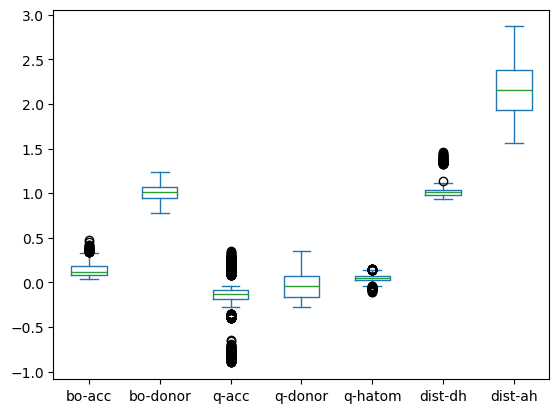

In [4]:
# Boxplot to have a basic check for obvious outliers
df.drop(columns=["energy"]).plot(kind="box")
plt.show()

In [5]:
# Check for missing values
print('Missing values:', df.isnull().sum().sum())

Missing values: 0


### Prepare train and test data

We will apply similar preprocessing steps we've alreday seen in the regression session on day 1.  
This time, we will also keep 5% of the data for a final validation on prediction quality after training.

In [6]:
# Get random 5% of data for validation
df_val = df.sample(frac=0.05, random_state=42)
# Drop those validation data from training data
df_tt = df.drop(df_val.index)
print(f"Training/Test data shape: {df_tt.shape}, Validation data shape: {df_val.shape}")


Training/Test data shape: (1556, 10), Validation data shape: (82, 10)


In [7]:
# Separate features and target
target_col = "energy"

X = df_tt.drop(columns=[target_col])
# We need y to be a 2-D array (n_samples x n_features)
y = df_tt[target_col].to_numpy().reshape(-1, 1)

In [8]:
# Get train and test splits
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
# Preprocess and transform features
numerical_features = X.select_dtypes(include=["number"]).columns.tolist()
categorical_features = X.select_dtypes(include=["object"]).columns.tolist()

# Define scaling and encoding for X
x_preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numerical_features),
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), categorical_features),
    ],
    remainder="drop",
)
# Define scaling for y
y_scaler = StandardScaler()

# Fit scaling for X on train data only, apply (transform) scaling to both train and test
X_train_t = x_preprocessor.fit_transform(X_train)
X_test_t = x_preprocessor.transform(X_test)

# Fit scaling for y on train data only, apply (transform) scaling to both train and test
y_train_t = y_scaler.fit_transform(y_train)
y_test_t = y_scaler.transform(y_test)

# Get transformed feature names (handy for inspection)
feat_names = x_preprocessor.get_feature_names_out()
    
# Inspect transformed data
print("X_train: ", X_train_t.shape)
print("X_test:  ", X_test_t.shape)
print("y_train: ", y_train_t.shape)
print("y_test:  ", y_test_t.shape)
display(pd.DataFrame(X_train_t, columns=feat_names).head(5))

X_train:  (1244, 16)
X_test:   (312, 16)
y_train:  (1244, 1)
y_test:   (312, 1)


,num__bo-acc,num__bo-donor,num__q-acc,num__q-donor,num__q-hatom,num__dist-dh,num__dist-ah,cat__atomtype-acc_Cl,cat__atomtype-acc_F,cat__atomtype-acc_N,cat__atomtype-acc_O,cat__atomtype-acc_S,cat__atomtype-don_F,cat__atomtype-don_N,cat__atomtype-don_O,cat__atomtype-don_S
0,-1.285813,0.917745,-0.115091,-0.282173,0.864921,-0.662341,1.298361,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,-0.647649,0.186561,0.970476,-0.771634,-0.619231,-0.258013,1.832981,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
2,-1.162635,-0.394051,0.083728,-0.078369,0.426753,-0.294188,0.813984,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
3,0.306321,-0.886830,0.274388,0.630579,0.169388,-0.271833,-1.260058,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
4,2.782975,0.231048,-2.398073,-1.403848,-1.551664,-0.384992,-0.519736,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [10]:
pd.DataFrame(X_train_t, columns=feat_names).describe().T

,count,mean,std,min,25%,50%,75%,max
num__bo-acc,1244.0,-3.726922e-16,1.000402,-1.391955,-0.783930,-0.226356,0.561194,4.424904
num__bo-donor,1244.0,-2.077652e-16,1.000402,-2.635512,-0.825518,0.005761,0.690747,2.512432
num__q-acc,1244.0,3.212864e-17,1.000402,-2.898847,-0.137707,0.108404,0.269204,1.999119
num__q-donor,1244.0,1.427940e-18,1.000402,-1.572323,-0.879873,-0.095105,0.625609,2.481237
num__q-hatom,1244.0,-1.427940e-18,1.000402,-3.597710,-0.516487,0.048946,0.545109,2.483628
num__dist-dh,1244.0,1.115221e-15,1.000402,-1.019973,-0.572710,-0.260462,-0.034062,3.766413
num__dist-ah,1244.0,5.026347e-16,1.000402,-2.028257,-0.781578,0.003296,0.792599,2.457190
cat__atomtype-acc_Cl,1244.0,5.707395e-02,0.232077,0.000000,0.000000,0.000000,0.000000,1.000000
cat__atomtype-acc_F,1244.0,3.617363e-02,0.186797,0.000000,0.000000,0.000000,0.000000,1.000000
cat__atomtype-acc_N,1244.0,1.302251e-01,0.336686,0.000000,0.000000,0.000000,0.000000,1.000000


## Build and train model with PyTorch

In [11]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim
from tqdm.auto import tqdm

import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)

In [12]:
# Check if GPU is available to be used with pytorch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


### Define objects for model and training process

In [13]:
# Define the model with a parameterizable architecture
class MLPRegressorTorch(nn.Module):
    def __init__(self, in_dim, hidden=(64, 32), dropout=0.1):
        super().__init__()
        layers = []
        prev = in_dim
        for h in hidden:
            layers += [
                # fully connected layer from prev inputs to h outputs
                nn.Linear(prev, h), 
                # non-linear activation with rectified linear unit
                nn.ReLU(), 
                # regularization via dropout: randomly zeroes activations with probability
                nn.Dropout(dropout) 
                ]
            prev = h
        # Last layer is regression output with a single neuron for continuous value
        layers += [nn.Linear(prev, 1)]
        self.net = nn.Sequential(*layers)

    def forward(self, x): 
        return self.net(x)

In [14]:
# Define function to create pytorch data loaders
def make_loaders(X_train_t, y_train_t, X_test_t, y_test_t, batch_size):
    # Convert data (numpy arrays) to torch tensors
    X_train_ts = torch.tensor(X_train_t, dtype=torch.float32)
    y_train_ts = torch.tensor(y_train_t, dtype=torch.float32)
    X_test_ts = torch.tensor(X_test_t, dtype=torch.float32)
    y_test_ts = torch.tensor(y_test_t, dtype=torch.float32)
    # Build torch dataset and dataloader for batches
    train_loader = DataLoader(TensorDataset(X_train_ts, y_train_ts), batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(TensorDataset(X_test_ts, y_test_ts), batch_size=batch_size, shuffle=False)

    return train_loader, test_loader

In [15]:
# Define function for training loop with hyperparameter configuration
# Also define a directory to store model checkpoints during training
CKPT_DIR = "optuna_ckpts"
os.makedirs(CKPT_DIR, exist_ok=True)

def objective(trial):
    # Define hyperparameter search space for optuna
    hidden_layers_list = [(256, 128, 64), (128, 64), (64, 32), (64,)]
    idx = trial.suggest_int("hidden_layers_idx", 0, len(hidden_layers_list)-1)
    hidden_layers = hidden_layers_list[idx]
    dropout = trial.suggest_float("dropout", 0.0, 0.3)
    lr = trial.suggest_float("lr", 5e-4, 3e-3, log=True)
    #lr = 0.1
    weight_decay = trial.suggest_float("weight_decay", 1e-6, 1e-3, log=True)
    batch_size = trial.suggest_categorical("batch_size", [16, 32, 64, 128, 256])
    epochs = 50

    # Get data loaders for train and test data
    train_loader, test_loader = make_loaders(X_train_t, y_train_t, X_test_t, y_test_t, batch_size)

    # Initialise model and put to device (CPU or GPU)
    model = MLPRegressorTorch(
        in_dim=X_train_t.shape[1],
        hidden=hidden_layers,
        dropout=dropout
        ).to(device)
    # Define optimizer: Adam with weight decay (L2 regularization)
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    # Define loss function: Mean Squared Error
    loss_fn = nn.MSELoss()

    # Check model progress and store checkpoints
    best_rmse = float("inf")
    best_ckpt_path = os.path.join(CKPT_DIR, f"best_trial.pt")

    # Run epochs for training with validation at the end of each epoch
    for epoch in tqdm(range(epochs), desc="Epochs", leave=False):
        # Train for one epoch and update model parameters
        model.train()
        train_loss = 0.0
        for x_batch, y_batch in train_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            pred = model(x_batch)
            loss = loss_fn(pred, y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * x_batch.size(0)
        train_loss /= len(train_loader.dataset)

        # Validate in this epoch for test data without updating model parameters
        model.eval()
        val_loss = 0.0
        preds, trues = [], []
        with torch.no_grad():
            for x_batch, y_batch in test_loader:
                x_batch = x_batch.to(device)
                pred = model(x_batch)
                val_loss += loss_fn(pred, y_batch.to(device)).item() * x_batch.size(0)
                preds.append(pred.cpu().numpy())
                trues.append(y_batch.cpu().numpy())
        val_loss /= len(test_loader.dataset)

        # Get RMSE in original units (invert scaling for y)
        y_pred = y_scaler.inverse_transform(np.vstack(preds))
        y_true = y_scaler.inverse_transform(np.vstack(trues))
        val_rmse = math.sqrt(float(np.mean((y_pred - y_true) ** 2)))

        # Report to Optuna
        trial.report(val_rmse, step=epoch)
        trial.set_user_attr(f"train_loss_epoch_{epoch}", float(train_loss))
        trial.set_user_attr(f"val_loss_epoch_{epoch}", float(val_loss))
        trial.set_user_attr(f"val_rmse_epoch_{epoch}", val_rmse)
        if trial.should_prune():
            raise optuna.TrialPruned()

        # Store model checkpoint if model improved
        if val_rmse < best_rmse:
            best_rmse = val_rmse
            torch.save(
                {
                    "state_dict": model.state_dict(),
                    "model_params": {
                        "in_dim": X_train_t.shape[1],
                        "hidden": hidden_layers,
                        "dropout": dropout,
                    },
                },
                best_ckpt_path,
            )
            trial.set_user_attr("best_model_ckpt", best_ckpt_path)
            trial.set_user_attr("best_val_rmse", best_rmse)
        
    return val_rmse   

### Run training with hyperparameter optimization

In [16]:
# Run model training and hyperparameter optimization with optuna study
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=20, timeout=600)

Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

## Evaluate model

In [17]:
best_trial = study.best_trial
best_params = best_trial.params
display("Params:", best_params)
print("Best RMSE:", best_trial.value)

'Params:'

{'hidden_layers_idx': 1,
 'dropout': 0.08436995612384487,
 'lr': 0.0027353884778077557,
 'weight_decay': 1.3565682991643851e-06,
 'batch_size': 16}

Best RMSE: 2.367166953422588


In [18]:
# Get all trials as DataFrame
df_all = study.trials_dataframe()

# Get best trial and its attributes
df_best = df_all[df_all["number"] == study.best_trial.number]
attrs = best_trial.user_attrs

In [19]:
# Collect metrics per epoch
records = []
max_epochs = max(
    int(k.split("_")[-1]) for k in attrs.keys() if "epoch" in k
) + 1

for epoch in range(max_epochs):
    record = {
        "epoch": epoch,
        "train_loss": attrs.get(f"train_loss_epoch_{epoch}"),
        "val_loss": attrs.get(f"val_loss_epoch_{epoch}"),
        "val_rmse_orig": attrs.get(f"val_rmse_epoch_{epoch}"),
    }
    if all(v is not None for v in record.values()):
        records.append(record)

df_epochs = pd.DataFrame(records).set_index("epoch")
print(df_epochs.head())

       train_loss  val_loss  val_rmse_orig
epoch                                     
0        0.212837  0.057968       7.368030
1        0.062150  0.028728       5.186882
2        0.054407  0.024758       4.815195
3        0.044266  0.022345       4.574517
4        0.037966  0.021755       4.513753


<class 'pandas.core.frame.DataFrame'>
Index: 50 entries, 0 to 49
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   train_loss     50 non-null     float64
 1   val_loss       50 non-null     float64
 2   val_rmse_orig  50 non-null     float64
dtypes: float64(3)
memory usage: 1.6 KB


None

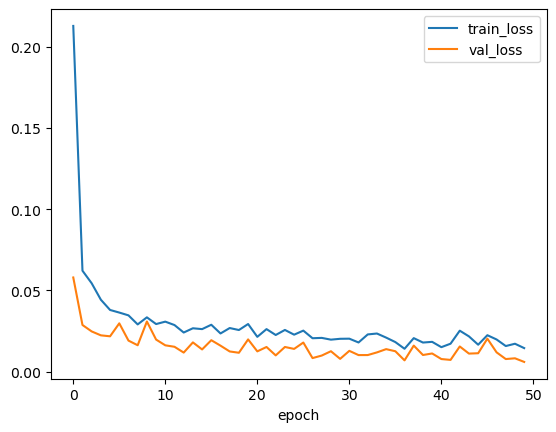

In [20]:
# Inspect and plot training history for best trial
display(df_epochs.info())
df_epochs[['train_loss', 'val_loss']].plot(legend=True)
plt.show()

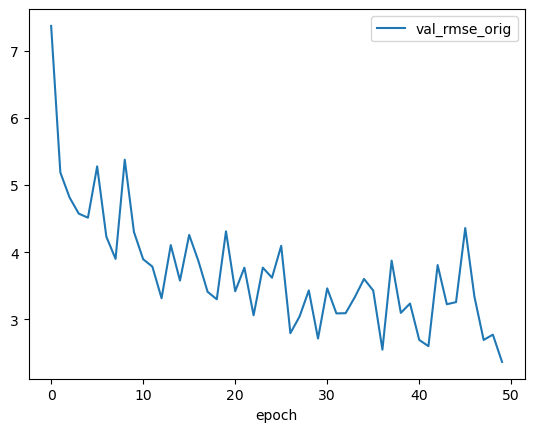

Best RMSE:  2.367166953422588


In [21]:
df_epochs.val_rmse_orig.plot(legend=True)
plt.show()
print("Best RMSE: ", df_epochs.val_rmse_orig.min())

## Load pretrained model and predict

Now we can load a model with our best parameter settings. We use our checkpoint for this. We finally want to predict on our validation data we sempled at the very beginning.

In [22]:
ckpt_path = best_trial.user_attrs["best_model_ckpt"]
ckpt = torch.load(ckpt_path, map_location=device)

In [23]:
# Our checkpoint contains the state dict with the trained model parameters
list(ckpt["state_dict"].items())[0]

('net.0.weight',
 tensor([[ 1.2998e-01, -5.8599e-02, -9.1701e-03,  ...,  8.2666e-02,
          -2.6167e-01, -1.7932e-01],
         [ 1.2702e-01,  6.9853e-02, -1.2293e-01,  ...,  1.6299e-02,
          -1.6481e-02, -4.8893e-04],
         [-1.5479e-02,  1.0947e-01,  6.0697e-01,  ..., -1.0442e-02,
          -1.9027e-01,  2.7875e-03],
         ...,
         [ 1.3420e-01, -5.1409e-02,  9.5353e-03,  ..., -7.1964e-02,
          -7.3765e-02, -5.6624e-02],
         [-2.4891e-01, -2.2578e-01,  4.7792e-01,  ..., -2.1212e-01,
           1.6324e-01,  2.6180e-03],
         [-1.8884e-01, -3.5862e-02, -1.8236e-01,  ..., -1.3896e-01,
          -5.1755e-02, -2.4016e-03]]))

In [24]:
best_model = MLPRegressorTorch(
    in_dim=ckpt["model_params"]["in_dim"],
    hidden=ckpt["model_params"]["hidden"],
    dropout=ckpt["model_params"]["dropout"],
).to(device)
best_model.load_state_dict(ckpt["state_dict"])
best_model.eval()

MLPRegressorTorch(
  (net): Sequential(
    (0): Linear(in_features=16, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.03769065706514282, inplace=False)
    (3): Linear(in_features=128, out_features=64, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.03769065706514282, inplace=False)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

In [25]:
# Separate features and target
X_val = df_val.drop(columns=["energy"])
y_val = df_val["energy"]

# Apply same scaler(s) used for training
X_val_t = x_preprocessor.transform(X_val)
y_val_t = y_scaler.transform(y_val.values.reshape(-1, 1))

# Convert to torch tensors
X_val_ts = torch.tensor(X_val_t, dtype=torch.float32).to(device)
y_val_ts = torch.tensor(y_val_t, dtype=torch.float32).to(device)

In [26]:
with torch.no_grad():
    y_pred_t = best_model(X_val_ts).cpu().numpy()

# Invert scaling for predictions and targets
y_pred = y_scaler.inverse_transform(y_pred_t)
y_true = y_scaler.inverse_transform(y_val_ts.cpu().numpy())

In [27]:
# Validate with regression metrics
from sklearn.metrics import mean_squared_error, r2_score

rmse = np.sqrt(mean_squared_error(y_true, y_pred))
r2   = r2_score(y_true, y_pred)

print(f"RMSE on validation sample: {rmse:.3f}")
print(f"R2-score on validation sample: {r2:.3f}")

RMSE on validation sample: 2.065
R2-score on validation sample: 0.994


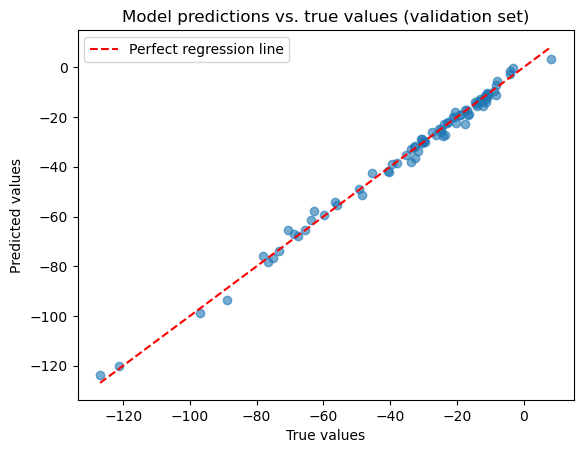

In [28]:
# Plot predictions vs true values
plt.scatter(y_true, y_pred, alpha=0.6)
plt.title("Model predictions vs. true values (validation set)")
plt.xlabel("True values")
plt.ylabel("Predicted values")
plt.plot(
    [y_true.min(), y_true.max()], 
    [y_true.min(), y_true.max()], 
    "r--", label="Perfect regression line")
plt.legend()
plt.show()